In [649]:
from typing import Optional, Union, NamedTuple

import numpy

import jax.numpy as jumpy
import jax.lax
import jax.random

import polars
import matplotlib.pyplot as mplot

mplot.ioff()

In [539]:
class Plot(NamedTuple):
    
    fig: mplot.Figure
    faxes: Union[list[mplot.Axes], list[list[mplot.Axes]]]
    
    @classmethod
    def create(
        cls,
        fig_kw = None,
        grid = None,
        grid_kw = None,
    ):
        fig_kw = {} if fig_kw is None else fig_kw
        grid_kw = {} if grid_kw is None else grid_kw
        # TODO: squeeze false
        if grid is not None:
            fig, axes = mplot.subplots(*grid, **grid_kw, **fig_kw)
        else:
            fig, axes = mplot.subplots(**grid_kw, **fig_kw)
        return Plot(fig, axes)
    
    def axes(self, grid = None):
        fig_axes = self.faxes
        if grid is None:
            assert isinstance(fig_axes, mplot.Axes), self
            axes = fig_axes
        else:
            axes = fig_axes
            if isinstance(axes[0], mplot.Axes):
                assert grid[0] == 0, grid
                grid = grid[1:]
            for i in grid:
                axes = axes[i]
        return axes
        
    def set(self, grid = None, **kw):
        axes = self.axes(grid)
        axes.set(**kw)
        
    def plot(
        self,
        x,
        v, 
        d: int = 1, 
        labels: Optional[list]=None,
        grid = None,
        legend = {},
    ):
        axes = self.axes(grid)
        
        if labels is None:
            labels = [f"v{i}" for i in range(v.shape[d])]
            
        for i in range(v.shape[d]):
            if d == 0:
                vv = v[i, :]
            elif d == 1:
                vv = v[:, i]
            else:
                raise ValueError(d)
            
            _ = axes.plot(x, vv, label=labels[i])
    
        self.set_legend(axes, **legend)
        return self

    def set_legend(self, ax, x = -.25, y = 1, width = 0.95, height = 1.):
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * width, box.height * height])
    
        ax.legend(loc='upper left', bbox_to_anchor=(x, y))
    
    def plot_fs(
        self, x, d = None, grid = None, 
        legend = {},
        **fs,
    ):
        axes = self.axes(grid)
        for label, f in fs.items():
            y = f(x)
            if d is None:
                _ = axes.plot(x, y, label=label)
                continue
            for i in range(y.shape[d]):
                if d == 0:
                    _ = axes.plot(x, y[i, :], label = label + f"_{i}")
                elif d == 1:
                    _ = axes.plot(x, y[:, i], label = label + f"_{i}")
                else:
                    raise ValueError(d)
        
        self.set_legend(axes, **legend)
        
        return self
    
    def close(self):
        mplot.close(self.fig)
        return None
    
    def show(self, close = True):
        mplot.show(self.fig)
        if close:
            return self.close()
        return None

In [540]:
def logistic(vmax = 1, growth = 1, mid = 0, a = 0, b = 1, m = 1, c = 0, e = 0):
    def f(x, **kwargs):
        g = kwargs.get("growth", growth)
        x = a + (b * x)
        y = vmax / (1 + jumpy.exp(- g * (x - mid)))
        return (m * (y + e)) + c
    return f
sigmoid = logistic(1, 1, 0)

In [541]:
def log(base):
    def f(x):
        return jumpy.log(x) / jumpy.log(base)
    return f

In [542]:
def grad(f):
    def g(*args, **kwargs):
        y = f(*args, **kwargs)
        return jumpy.gradient(y)
    return g

In [543]:
def log_then(base, f):
    l = log(base)
    def g(x):
        log_x = l(x)
        return f(log_x)
    return g

In [556]:
def level(k=4, height = 1):
    f = logistic(1, 1/k, 0, e = -.5, m = height / .5)
    def g(x, **kwargs):
        return f(x, **kwargs)
    return g

def slope(k = 4, height = 1):
    f = logistic(1, 1/k, 0, m = 2, c = -1.5)
    def g(x, **kwargs):
        return f(x, **kwargs) * (height / .5)
    return g

In [545]:
def delta(f1, f2):
    def g(x):
        return f1(x) - f2(x)
    return g

def ratio(f1, f2):
    def g(x):
        return f1(x) / f2(x)
    return g

def inverse(f):
    def g(x):
        return 1 / f(x)
    return g

def square(f):
    def g(x):
        return f(x) * f(x)
    return g

In [546]:
def curve(mid, slope = 16, k = 1, height = 1):
    f = logistic(1, 1, 0, m = 2, c = -1.5)
    def g(x):
        return f(((x - mid) / slope) ** 2) * (height / .5)
    return g

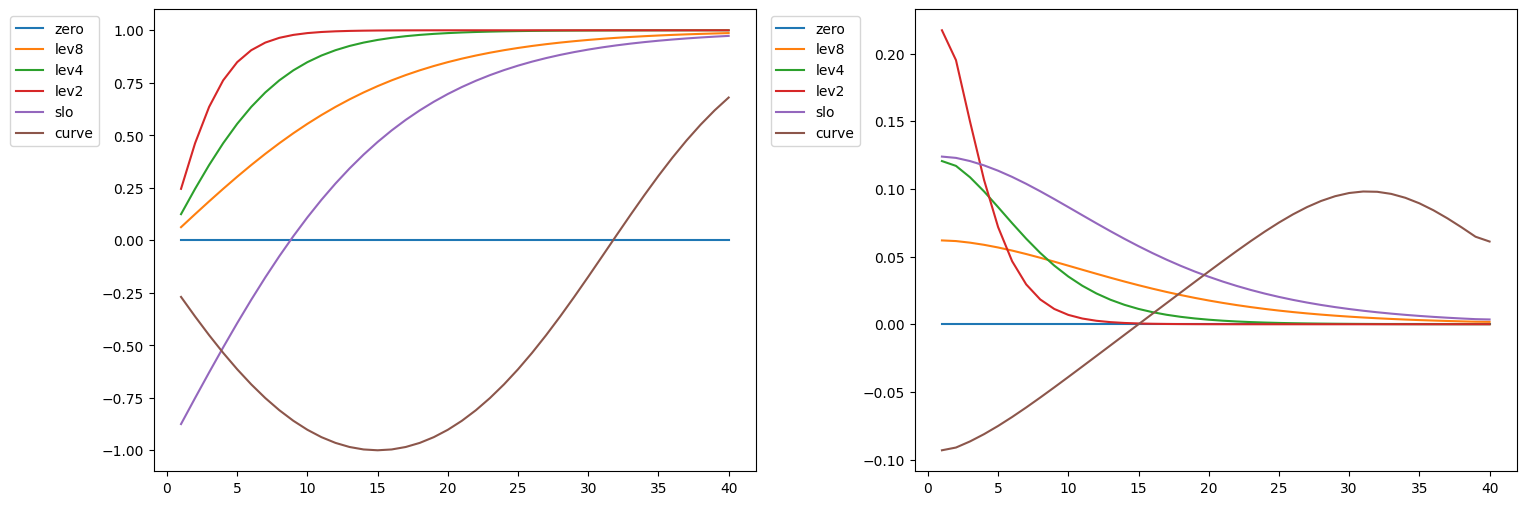

In [585]:
fs = {
    "zero": lambda x: x * 0,
    "lev8": level(8),
    "lev4": level(4),
    "lev2": level(2),
    "slo": slope(8),
    "curve": curve(15)
    # "log_lev": log_then(2, level(4)),
}

Plot.create(
    grid = (1, 2),
    fig_kw = dict(figsize = (9 * 2, 6))
).plot_fs(
    jumpy.linspace(1, 40, 40),
    grid = (0, 0),
    **fs,
).plot_fs(
    jumpy.linspace(1, 40, 40),
    grid = (0, 1),
    **{k: grad(f) for k, f in fs.items()},
).show()

In [548]:
date = lambda: polars.col("DATE")
zyield = lambda mat: polars.col(f"THREEFY{mat}").alias("Z:" + str(mat).rjust(2, "0") + "Y")
cyield = lambda rat, mat: polars.col(f"{rat}{mat}Y").alias(rat + ":" + str(mat).rjust(2, "0") + "Y")
cspread = lambda rat: polars.col(f"D{rat}")

AAA = "AAA"
BAA = "BAA"

In [549]:
raw_data = polars.read_csv("./yields.csv").with_columns(
    date().str.to_date(),
    *(
        polars.col(k)
        .replace({".": None})
        .cast(polars.Float64) 
        for k in data.schema.keys()
        if k != "DATE"
    )
)
raw_data

DATE,AAA10Y,DAAA,BAA10Y,DBAA,THREEFY1,THREEFY10,THREEFY2,THREEFY3,THREEFY4,THREEFY5,THREEFY6,THREEFY7
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1990-11-26,0.96,9.23,2.25,10.52,7.2793,8.3114,7.4424,7.5829,7.7089,7.8248,7.9332,8.0354
1990-11-27,0.93,9.21,2.23,10.51,7.2897,8.3246,7.4563,7.598,7.7242,7.8399,7.9479,8.0497
1990-11-28,0.9,9.2,2.22,10.52,7.3224,8.3552,7.4954,7.6384,7.7637,7.8778,7.984,8.0842
1990-11-29,0.85,9.17,2.23,10.55,7.3394,8.367,7.5199,7.6639,7.7876,7.8993,8.0031,8.101
1990-11-30,0.91,9.17,2.27,10.53,7.3188,8.3292,7.4955,7.6361,7.7571,7.8667,7.9688,8.0655
…,…,…,…,…,…,…,…,…,…,…,…,…
2024-11-20,0.79,5.2,1.43,5.84,4.372,4.4531,4.2762,4.2143,4.1874,4.1904,4.2168,4.2607
2024-11-21,0.79,5.22,1.43,5.86,4.3931,4.4681,4.3029,4.2414,4.213,4.2138,4.2381,4.28
2024-11-22,0.81,5.22,1.43,5.84,4.4062,4.4643,4.3178,4.2545,4.2229,4.2206,4.242,4.2815


In [550]:
def unpack_col_range(df, start, stop=None):
    if stop is None:
        stop = len(df.schema) + 1
    ks = list(df.schema.keys())[start: stop]
    return dict(
        v = df.select(ks).to_numpy(),
        labels=ks,
    )

In [551]:
data = raw_data.filter(
    polars.all_horizontal(
        polars.col(k).is_not_null()
        for k in raw_data.schema.keys()
    )
)

In [591]:
yields_df = data.select(
    "DATE",
     *(   
        zyield(i) for i in range(1, 11)
        if i not in {8, 9}
    )
)
yields_nd = jumpy.array(
    yields_df.select(
        list(yields_df.schema.keys())[1:]
    )
    .to_numpy()
)
yields_nd.shape

(8481, 8)

In [ ]:
def model_level(yields, mats, f_level, steps, init, clip):

    init_scale = init.get("scale", numpy.max(yields[0, :]))
    init_slope = init.get("slope", 8.)

    step_scale = steps.get("scale", .1)
    step_slope = steps.get("slope", .1)

    clip_scale = clip.get("scale", 3.)
    clip_slope = clip.get("slope", 3.)

    n = yields.shape[1]
    
    def f_error(
        ms, ys, scale, slope,
    ):
        yield_pred = f_level(ms, growth = jumpy.exp(slope)) * jumpy.exp(scale)
        return (yield_pred - ys) ** 2
    
    def err_grad_wrt_scale(ms, ys, slope):
        def f(scale):
            return f_error(ms, ys, scale, slope)
        f_grad = grad(f)
        def f_err(scale):
            g = f_grad(scale)
            error = f_error(ms, ys, scale, slope)
            return jumpy.clip(jumpy.dot(g, error) / n, min=-clip_scale, max = clip_scale)
        return f_err
    
    def err_grad_wrt_slope(ms, ys, scale):
        def f(slope):
            return f_error(ms, ys, scale, slope)
        f_grad = grad(f)
        def f_err(slope):
            g = f_grad(slope)
            error = f_error(ms, ys, scale, slope)
            return jumpy.clip(jumpy.dot(g, error) / n, min=-clip_slope, max = clip_slope)
        return f_err
    
    def f_scan(acc, x):
        scale, slope = acc
        
        ms = x[:n]
        ys = x[n:int(n*2)]

        scale_err = err_grad_wrt_scale(ms, ys, slope)(scale)
        scale = scale + (step_scale * scale_err)

        slope_err = err_grad_wrt_slope(ms, ys, scale)(slope)
        slope = slope + (step_slope * slope_err)

        y_pred = f_level(ms, growth=jumpy.exp(slope)) * jumpy.exp(scale)
        
        return (scale, slope), (
            jumpy.exp(scale), 
            jumpy.exp(slope),
            scale_err,
            slope_err,
            y_pred
        )

    x = jumpy.hstack((
        jumpy.tile(
            jumpy.array(mats), yields.shape[0]
        ).reshape(yields.shape),
        yields, 
    ))

    test_args = (x[0, :n], x[0, n:n*2], 1., 1.)
    
    # print(f_error(*test_args))
    # print(f_level(x[0, :n], growth=4.))
    # print(jumpy.exp(jumpy.log(init_scale)))
    # print(jumpy.exp(jumpy.log(init_slope)))
    
    (_, _), (
        scales, slopes, scale_err, slope_err, preds
    ) = jax.lax.scan(
        f_scan, 
        (
            jumpy.log(init_scale),
            jumpy.log(init_slope)
        ), 
        xs=x
    )

    pl_s = lambda v, k: polars.Series(numpy.array(v)).alias(k)
    
    res = polars.DataFrame([
        pl_s(scales, "scale").ewm_mean(span=12),
        pl_s(slopes, "slope").ewm_mean(span=12),
        pl_s(scale_err, "scale_err"),
        pl_s(slope_err, "slope_err"),
    ] + [
        pl_s(preds[:, i], str(mat).rjust(2, "0") + "Y").ewm_mean(span=12)
        for i, mat in enumerate(mats)
    ])

    return res

In [691]:
def model_level_slope(yields, mats, f_level, f_slope, steps, init, clip, rnd_seed = 13):

    init_l_scale = init.get("s_scale", numpy.mean(yields[0, :]))
    init_l_slope = init.get("s_slope", 8.)

    init_s_scale = init.get("s_scale", numpy.std(yields[0, :]))
    init_s_slope = init.get("s_slope", 4.)

    step_l_scale = steps.get("l_scale", .1)
    step_l_slope = steps.get("l_slope", .1)
    
    step_s_scale = steps.get("s_scale", .1)
    step_s_slope = steps.get("s_slope", .1)

    clip_l_scale = clip.get("l_scale", 3.)
    clip_l_slope = clip.get("l_slope", 3.)
    
    clip_s_scale = clip.get("s_scale", 3.)
    clip_s_slope = clip.get("s_slope", 3.)

    n = yields.shape[1]

    def f_pred(ms, l_scale, l_slope, s_scale, s_slope):
        yield_level = f_level(ms, growth = jumpy.exp(l_slope)) + jumpy.exp(l_scale)
        yield_slope = f_slope(ms, growth = jumpy.exp(s_slope)) * s_scale
        yield_pred = yield_level + yield_slope
        return yield_pred
    
    def f_error(
        ms, ys, l_scale, l_slope, s_scale, s_slope, 
    ):
        yield_pred = f_pred(ms, l_scale, l_slope, s_scale, s_slope)
        return yield_pred - ys
    
    def err_grad_wrt(ms, ys, k, v_clip, rnd_key=None, rnd_n = 10, **kwargs):
        if rnd_key is not None:
            ys = (jumpy.resize(ys, (rnd_n, ys.shape[0])) + (
                jax.random.normal(
                    rnd_key, (rnd_n, ys.shape[0])
                ) / 10
            )).reshape(rnd_n * ys.shape[0])
            ms = jumpy.resize(ms, (rnd_n, ms.shape[0])).reshape(rnd_n * ms.shape[0])
        def f(v):
            return f_error(ms, ys, **{
                **kwargs,
                **{k: v}
            })
        f_grad = grad(f)
        def f_err(v):
            g = f_grad(v)
            error = f_error(ms, ys, **{
                **kwargs,
                **{k: v}
            })
            return jumpy.clip(jumpy.dot(g, error) / n, min=-v_clip, max = v_clip)
        return f_err
    
    def f_scan(acc, x):
        l_scale, l_slope, s_scale, s_slope, rnd_key = acc
                
        ms = x[:n]
        ys = x[n:int(n*2)]

        rnd_key, rnd_subkey = jax.random.split(rnd_key)
        l_scale_err = err_grad_wrt(
            ms,
            ys,
            "l_scale",
            clip_l_scale,
            # l_scale=l_scale,
            l_slope=l_slope,
            s_scale=s_scale,
            s_slope=s_slope,
            rnd_key=rnd_subkey,
        )(l_scale)
        l_scale = l_scale + (step_l_scale * l_scale_err)

        rnd_key, rnd_subkey = jax.random.split(rnd_key)
        s_scale_err = err_grad_wrt(
            ms,
            ys,
            "s_scale",
            clip_s_scale,
            l_scale=l_scale,
            l_slope=l_slope,
            # s_scale=s_scale,
            s_slope=s_slope,
            rnd_key=rnd_subkey,
        )(s_scale)        
        s_scale = s_scale + (step_s_scale * s_scale_err)

        rnd_key, rnd_subkey = jax.random.split(rnd_key)
        l_slope_err = err_grad_wrt(
            ms,
            ys,
            "l_slope",
            clip_l_slope,
            l_scale=l_scale,
            # l_slope=l_slope,
            s_scale=s_scale,
            s_slope=s_slope,
            rnd_key=rnd_subkey,
        )(l_slope)
        l_slope = l_slope + (step_l_slope * l_slope_err)

        rnd_key, rnd_subkey = jax.random.split(rnd_key)
        s_slope_err = err_grad_wrt(
            ms,
            ys,
            "s_slope",
            clip_s_slope,
            l_scale=l_scale,
            l_slope=l_slope,
            s_scale=s_scale,
            # s_slope=s_slope,
            rnd_key=rnd_subkey,
        )(s_slope)
        
        s_slope = s_slope + (step_s_slope * s_slope_err)

        l_scale = jumpy.clip(l_scale, min=0, max=jumpy.log(10))
        s_scale = jumpy.clip(s_scale, min = -10, max = 10)

        l_slope = jumpy.clip(l_slope, min = 0, max = jumpy.log(15))
        s_slope = jumpy.clip(s_slope, min = 0, max = jumpy.log(15))

        y_pred = f_pred(ms, l_scale, l_slope, s_scale, s_slope)
        
        return (l_scale, l_slope, s_scale, s_slope, rnd_key), (
            jumpy.exp(l_scale), 
            jumpy.exp(l_slope),
            s_scale,
            jumpy.exp(s_slope),
            l_scale_err,
            l_slope_err,
            s_scale_err,
            s_slope_err,
            y_pred
        )

    x = jumpy.hstack((
        jumpy.tile(
            jumpy.array(mats), yields.shape[0]
        ).reshape(yields.shape),
        yields, 
    ))
    
    (_, _, _, _, _), (
        l_scales,
        l_slopes,
        s_scales,
        s_slopes,
        l_scale_err,
        l_slope_err, 
        s_scale_err,
        s_slope_err,
        preds
    ) = jax.lax.scan(
        f_scan, 
        (
            jumpy.log(init_l_scale),
            jumpy.log(init_l_slope),
            init_s_scale,
            jumpy.log(init_s_slope),
            jax.random.key(rnd_seed)
        ),
        xs=x
    )

    pl_s = lambda v, k: polars.Series(numpy.array(v)).alias(k)
    
    res = polars.DataFrame([
        pl_s(l_scales, "l_scale").ewm_mean(span=12),
        pl_s(l_slopes, "l_slope").ewm_mean(span=12),
        pl_s(s_scales, "s_scale").ewm_mean(span=12),
        pl_s(s_slopes, "s_slope").ewm_mean(span=12),
        pl_s(l_scale_err, "l_scale_err").ewm_mean(span=12),
        pl_s(l_slope_err, "l_slope_err").ewm_mean(span=12),
        pl_s(s_scale_err, "s_scale_err").ewm_mean(span=12),
        pl_s(s_slope_err, "s_slope_err").ewm_mean(span=12),
    ] + [
        pl_s(preds[:, i], str(mat).rjust(2, "0") + "Y").ewm_mean(span=12)
        for i, mat in enumerate(mats)
    ])

    return res

In [692]:
model_level_slope_res = model_level_slope(
    yields_nd,
    [i for i in range(1, 11) if i not in {8, 9}], 
    level(4), 
    slope(4),
    steps = dict(
        l_scale=.1,
        l_slope=.0,
        s_scale=.1,
        s_slope=.05,
    ),
    init = {},
    clip = {},
)
model_level_slope_res.head(2).pipe(print)
model_level_slope_res.tail(2).pipe(print)

shape: (2, 16)
┌──────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ l_scale  ┆ l_slope ┆ s_scale  ┆ s_slope  ┆ … ┆ 05Y      ┆ 06Y      ┆ 07Y      ┆ 10Y      │
│ ---      ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f32      ┆ f32     ┆ f32      ┆ f32      ┆   ┆ f32      ┆ f32      ┆ f32      ┆ f32      │
╞══════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 7.602192 ┆ 8.0     ┆ 0.301043 ┆ 3.971813 ┆ … ┆ 8.903234 ┆ 8.903234 ┆ 8.903234 ┆ 8.903234 │
│ 7.523499 ┆ 8.0     ┆ 0.291844 ┆ 3.952637 ┆ … ┆ 8.815343 ┆ 8.815343 ┆ 8.815343 ┆ 8.815343 │
└──────────┴─────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘
shape: (2, 16)
┌──────────┬─────────┬───────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ l_scale  ┆ l_slope ┆ s_scale   ┆ s_slope  ┆ … ┆ 05Y      ┆ 06Y      ┆ 07Y      ┆ 10Y      │
│ ---      ┆ ---     ┆ ---       ┆ ---

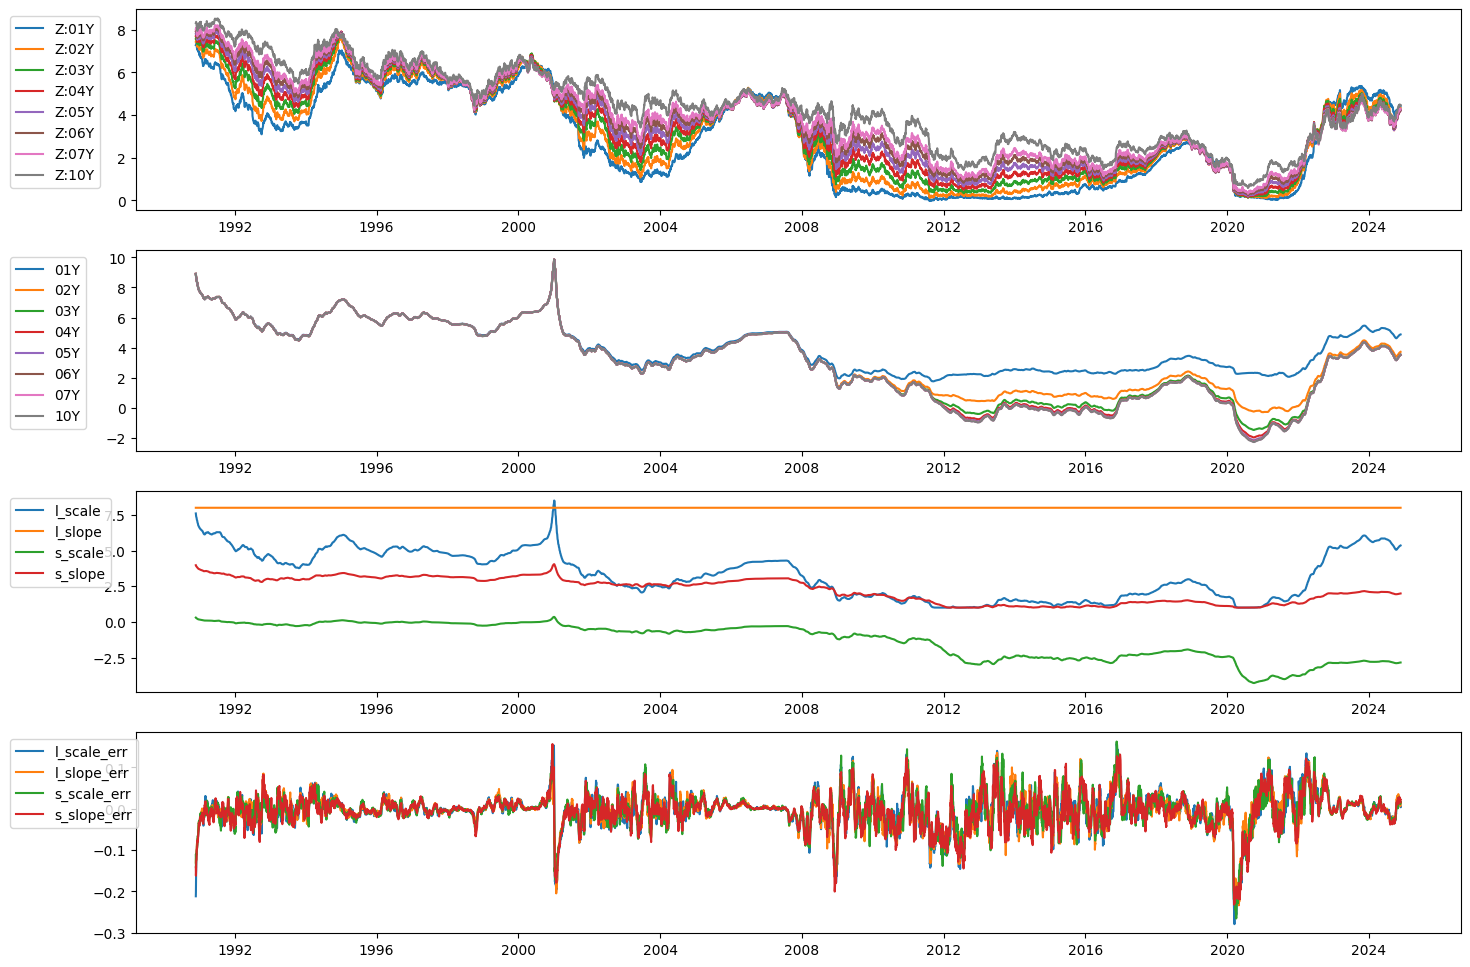

In [693]:
Plot.create(
    grid = (4, 1),
    fig_kw = dict(figsize = (9 * 2, 12))
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(yields_df, 1),
    grid = (0, 0),
    legend=dict(x=-.1),
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(model_level_slope_res, 8),
    grid = (0, 1),
    legend=dict(x=-.1),
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(model_level_slope_res, 0, 4),
    grid = (0, 2),
    legend=dict(x=-.1),
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(model_level_slope_res, 4, 8),
    grid = (0, 3),
    legend=dict(x=-.1),
).show()

In [ ]:
model_level_res = model_level(
    yields_nd,
    [i for i in range(1, 11) if i not in {8, 9}], 
    level(4), 
    steps = dict(
        scale=.1,
        slope=.1
    ),
    init = {},
    clip = {},
)
model_level_res.head(2).pipe(print)
model_level_res.tail(2).pipe(print)

shape: (2, 12)
┌──────────┬──────────┬───────────┬───────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ scale    ┆ slope    ┆ scale_err ┆ slope_err ┆ … ┆ 05Y      ┆ 06Y      ┆ 07Y      ┆ 10Y      │
│ ---      ┆ ---      ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f32      ┆ f32      ┆ f32       ┆ f32       ┆   ┆ f32      ┆ f32      ┆ f32      ┆ f32      │
╞══════════╪══════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 8.237702 ┆ 7.946445 ┆ -0.089066 ┆ -0.067169 ┆ … ┆ 8.237702 ┆ 8.237702 ┆ 8.237702 ┆ 8.237702 │
│ 8.208956 ┆ 7.924168 ┆ -0.064633 ┆ -0.051889 ┆ … ┆ 8.208956 ┆ 8.208956 ┆ 8.208956 ┆ 8.208956 │
└──────────┴──────────┴───────────┴───────────┴───┴──────────┴──────────┴──────────┴──────────┘
shape: (2, 12)
┌────────────┬────────────┬───────────┬───────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ scale      ┆ slope      ┆ scale_err ┆ slope_err ┆ … ┆ 05Y        ┆ 06Y        ┆ 07Y        ┆

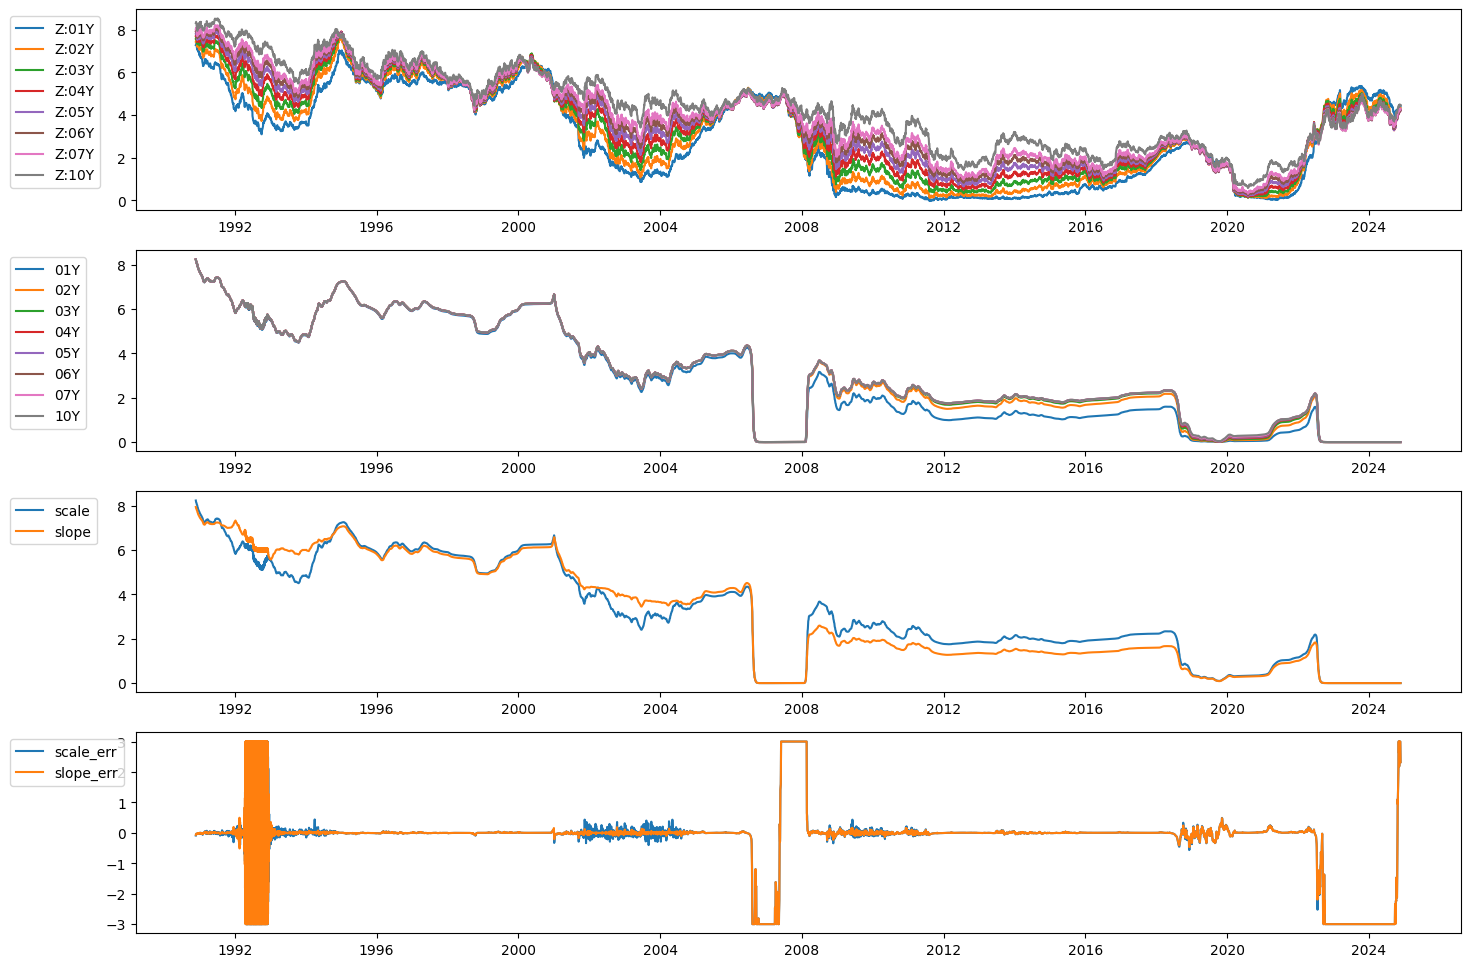

In [555]:
Plot.create(
    grid = (4, 1),
    fig_kw = dict(figsize = (9 * 2, 12))
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(yields_df, 1),
    grid = (0, 0),
    legend=dict(x=-.1),
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(model_level_res, 4),
    grid = (0, 1),
    legend=dict(x=-.1),
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(model_level_res, 0, 2),
    grid = (0, 2),
    legend=dict(x=-.1),
).plot(
    x=data.get_column("DATE"),
    **unpack_col_range(model_level_res, 2, 4),
    grid = (0, 3),
    legend=dict(x=-.1),
).show()